<a href="https://colab.research.google.com/github/AlejandraOcampo23/Ciencia-De-Datos/blob/main/Taller_final_CD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UEC**


**Finanzas y Relaciones Internacionales**

**Trabajo Final Ciencia de Datos**




**Catalina Naranjo**




**Alejandra Ocampo, Valentina Malagon, Mariangel Mantilla.**






# **Contexto y entendimiento del problema**


En principio lo que se busca en la elaboracion de este trabajo es predecir el tiempo de entrega de un paquete en pequeñas camionetas, las cuales fueron adquiridas por una compañía de transporte. Para poder realizar lo anterior se tienen algunas caracteristicas claves: 

1. El tiempo comienza a correr cuando todos los paquetes ya están dentro de la camioneta y el conductor enciende el motor.
2. El tiempo se detiene cuando el conductor llega a su destino para entregar el paquete.

En este sentido, para realizar las predicciones de tiempo de entrega se tienen las siguientes bases de datos: 



*   Train_principal
*   Train_info_geo
*   Train_clima
*   Test_principal
*   Test_info_geo
*   Test_clima

Por tanto, este trabajo contempla el objetivo de implementar todo lo visto en clase mediante el analisis de la informacion, el tratamiento de los datos, su transformacion, la aplicacion de modelos y el mejoramiento de los mismo mediente tecnicas de ajuste, con la finalidad de tener un valor de predicción correcto del tiempo de entrega de los paquetes.










In [ ]:
#Importamos las librerias y los datasets 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math 
import re
import warnings
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import time
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from geopy.distance import distance
!pip install dataprep
from dataprep.eda import create_report
from google.colab import files 
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
festivos=pd.read_csv("https://raw.githubusercontent.com/mariangelmantilla2008/Base-de-datos-taller-final-/main/festivos.csv")
test_clima=pd.read_csv("https://raw.githubusercontent.com/mariangelmantilla2008/Base-de-datos-taller-final-/main/test_clima.csv")
train_clima=pd.read_csv("https://raw.githubusercontent.com/mariangelmantilla2008/Base-de-datos-taller-final-/main/train_clima.csv")
test_info_geo=pd.read_csv("https://raw.githubusercontent.com/mariangelmantilla2008/Base-de-datos-taller-final-/main/test_info_geo.csv")
test_principal=pd.read_csv("https://raw.githubusercontent.com/mariangelmantilla2008/Base-de-datos-taller-final-/main/test_principal.csv")
train_principal=pd.read_csv("https://raw.githubusercontent.com/mariangelmantilla2008/Base-de-datos-taller-final-/main/train_principal.csv")
train_info_geo=pd.read_csv("https://raw.githubusercontent.com/mariangelmantilla2008/Base-de-datos-taller-final-/main/train_info_geo.csv")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Revision de los train

In [ ]:
train_principal.shape

(7220, 5)

In [ ]:
train_principal.head()

,id,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega
0,1,2016/04/14 20:53:00,modelo_1,3,448
1,2,2016/05/30 23:12:00,modelo_2,1,784
2,3,2016/03/03 11:54:00,modelo_2,1,844
3,4,2016/05/02 12:34:00,modelo_1,1,2076
4,5,2016/03/02 15:53:00,modelo_1,1,1289


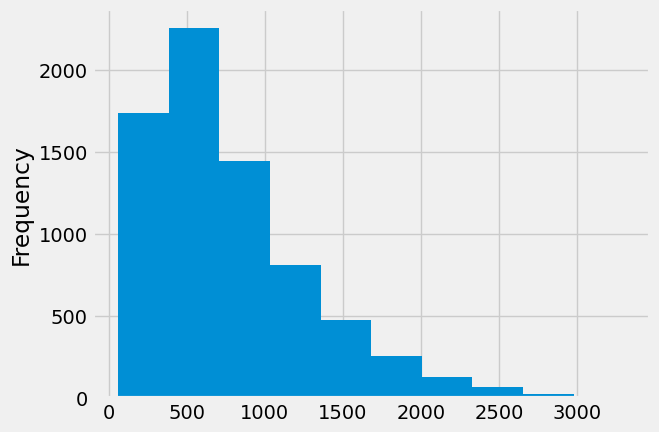

In [ ]:
#Distribucion de la variable objetivo
train_principal['tiempo_entrega'].astype(int).plot.hist();

En primer lugar podemos visualizar que la variable objetivo tiene una gran cantidad de datos entre 0 y 500; pero la mayoria de los datos estan entre 500 y 1000. Ahora bien la distribucion de esta variable objetivo tiene los datos concentrados hacia un costado presentando curtosis y una distibucion parecida a la Log-normal . 

In [ ]:
#Unimos los dos dataframes para trabajarlos al mismo tiempo
train_principal['dataset'] = 'train'
test_principal['dataset'] = 'test'
# El ID único de cada cliente, por lo que lo vamos a setear como índice de cada dataframe
train_principal.set_index('id', inplace=True)
test_principal.set_index('id', inplace=True)
# Unimos los dos df con append
train_test_principal = train_principal.append(test_principal) #Pegar algo por debajo 

train_test_principal.tail(1)

<ipython-input-364-0aa4f9ca7655>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_principal = train_principal.append(test_principal) #Pegar algo por debajo


,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega,dataset
id,,,,,
7578,2016/03/19 12:53:00,modelo_1,1,NaN,test


In [ ]:
#Unimos los dos dataframes para trabajarlos al mismo tiempo
train_clima['dataset'] = 'train'
test_clima['dataset'] = 'test'
# El ID único de cada cliente, por lo que lo vamos a setear como índice de cada dataframe
train_clima.set_index('id', inplace=True)
test_clima.set_index('id', inplace=True)
# Unimos los dos df con append
train_test_clima = train_clima.append(test_clima) #Pegar algo por debajo 

train_test_clima.tail(1)

<ipython-input-365-bde2c203442e>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_clima = train_clima.append(test_clima) #Pegar algo por debajo


,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,precipitacion,niebla,lluvia,nieve,dataset
id,,,,,,,,,,,,,
4403,bruma,11.7,8.9,83.0,NaN,0,9.7,29.7,0.3,No,No,No,test


In [ ]:
#Unimos los dos dataframes para trabajarlos al mismo tiempo
train_info_geo['dataset'] = 'train'
test_info_geo['dataset'] = 'test'
# El ID único de cada cliente, por lo que lo vamos a setear como índice de cada dataframe
train_info_geo.set_index('id', inplace=True)
test_info_geo.set_index('id', inplace=True)
# Unimos los dos df con append
train_test_info_geo = train_info_geo.append(test_info_geo) #Pegar algo por debajo 

train_test_info_geo.tail(1)

<ipython-input-366-edb8de1217ff>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test_info_geo = train_info_geo.append(test_info_geo) #Pegar algo por debajo


,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final,dataset
id,,,,,,
1147,Nueva York,-73.986427,40.767189,-73.983398,40.760872,test


In [ ]:
festivos.head()

,fecha,festivo
0,2016-01-01,1
1,2016-01-18,1
2,2016-02-12,1
3,2016-02-15,1
4,2016-05-08,1


La decision final con el dataset de festivos, es que no se va a usar porque no lo consideramos tan relevante. Pues el df solo contiene 12 datos y en comparacion con el tamaño de los otros df no es particularmente determinante. Adicionalmente, se tuvieron problema para añadir la variable sin dañar los Datasets 

#Unimos todos los Dataframes para trabajarlos simultaneamente

In [ ]:
data = pd.merge(train_test_principal, pd.merge(train_test_clima, train_test_info_geo, on='id', how='outer'), on='id', how='outer')
data.head(1)

,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,precipitacion,niebla,lluvia,nieve,dataset_x,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final,dataset_y
id,,,,,,,,,,,,,,,,,,,,,,,,
1,2016/04/14 20:53:00,modelo_1,3,448.0,train,despejado,8.9,0.0,54.0,16.7,170,16.1,30.4,NaN,No,No,No,train,Nueva York,-73.950912,40.825974,-73.94474,40.814163,train


In [ ]:
#Eliminamos estas columnas porque contienen la misma info que la colunma de Dataset, donde se estipula si un registro pertenece a test o a train
col_eliminar2 = ["dataset_x","dataset_y"]
data= data.loc[:,~data.columns.isin(col_eliminar2)]
data.head(3)

,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,precipitacion,niebla,lluvia,nieve,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final
id,,,,,,,,,,,,,,,,,,,,,,
1,2016/04/14 20:53:00,modelo_1,3,448.0,train,despejado,8.9,0.0,54.0,16.7,170,16.1,30.4,NaN,No,No,No,Nueva York,-73.950912,40.825974,-73.944740,40.814163
2,2016/05/30 23:12:00,modelo_2,1,784.0,train,parcialmente nublado,22.8,18.9,79.0,9.3,0,16.1,30.0,NaN,No,No,No,Nueva York,-73.985680,40.760487,-73.942482,40.786232
3,2016/03/03 11:54:00,modelo_2,1,844.0,train,despejado,0.0,-15.6,31.0,9.3,250,16.1,30.2,NaN,No,No,No,Nueva York,-73.985420,40.758389,-74.007294,40.726639


<ipython-input-370-9e1aadce3b3f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


(14.5, -0.5)

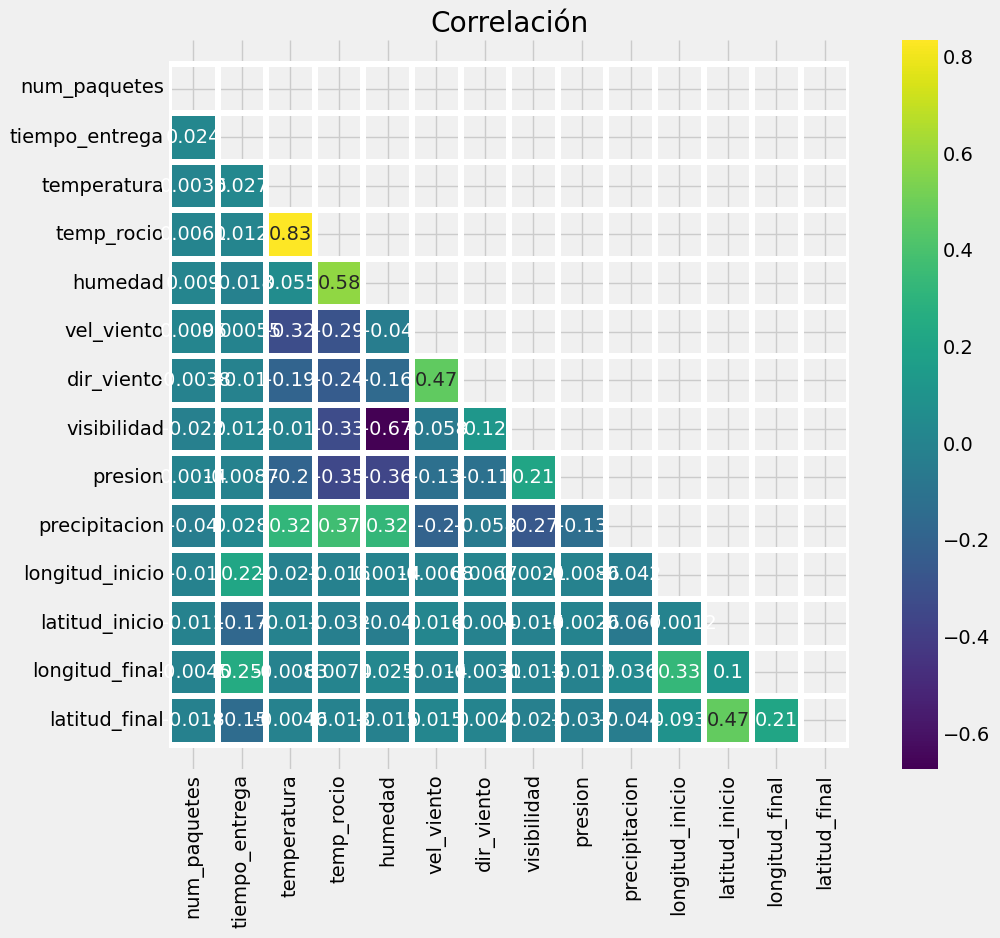

In [ ]:
correlation = data.corr()
f,ax =plt.subplots(figsize =(12,9))
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=mask , ax=ax, 
            linewidths = 4, cmap = 'viridis', square=True).set_title("Correlación")
bottom,top = ax.get_ylim()
ax.set_ylim (bottom + 0.5 , top - 0.5)

En este grafico se ven las correlaciones entre las variables. Destacandose la relacion fuertemente positiva entre la temperatura de rocio y temperatura. Humedad y temperatura de rocio. Y la relacion fuertemente negativa entre Visibilidad y Humedad 

In [ ]:
#Correlacion en todo el dataframne de train 
correlations = data.corr()["tiempo_entrega"].sort_values()
print('Most Positive Correlations:\n', correlations.tail(5))
print('\nMost Negative Correlations:\n', correlations.head(5))

Most Positive Correlations:
 temperatura        0.027070
precipitacion      0.027524
longitud_inicio    0.215718
longitud_final     0.247205
tiempo_entrega     1.000000
Name: tiempo_entrega, dtype: float64

Most Negative Correlations:
 latitud_inicio   -0.172163
latitud_final    -0.148103
humedad          -0.017518
dir_viento       -0.010254
presion          -0.008691
Name: tiempo_entrega, dtype: float64


<ipython-input-371-83907f04a185>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()["tiempo_entrega"].sort_values()


# Insight#1

En el codigo estamos buscando las variables que mas expliquen la variable objetivo. Las que mas la explican de forma directa y positiva son la temperatura, precipitacion y las cordenadas longitud. Por lo que estas variables seran una prioridad a la hora de la transformacion y creacion de variables nuevas. Por otro lado, de forma negativa las cordenadas de latitud es la que mas impacto real tiene.

In [ ]:
#create_report(data)

# Insight#2

Dentro de este reporte se pueden ver varias cosas interesantes en cuanto a la distibucion de todas las variables, su relacion y el tipo de datos que contienen. Lo mas interesante es que del dataset la variable tiempo_entrega tiene el 15% de datos faltantes, vel_viento el 7,7%, visibilidad el 2,7% presion 2,66% y precipitacion un 84.92% Por lo que toca tener cuidado con esa ultima especificamente. Y la variable ciudad solo tiene una categoria 

# Modificacion  de variables en el Dataset principal

In [ ]:
#Contamos los datos en lluvia 
data['lluvia'].value_counts()

No    7784
Si     710
Name: lluvia, dtype: int64

In [ ]:
#Contamos los datos en precipitacion
data['precipitacion'].value_counts()

0.0     339
0.3     283
0.5     148
0.8      95
1.0      84
1.3      49
1.5      38
1.8      35
2.3      32
2.0      32
3.0      30
2.5      20
2.8      13
6.1      10
3.6       9
6.6       8
10.4      7
3.3       6
5.1       5
3.8       4
6.9       4
5.8       4
7.4       3
4.1       2
9.4       2
11.7      2
9.1       2
4.8       2
14.7      2
12.7      2
4.6       2
10.2      2
18.5      2
8.9       1
5.6       1
5.3       1
Name: precipitacion, dtype: int64

In [ ]:
#Se hacen rangos para dividir precipitacion y se le dan categorias para precisar el estado del clima 
bins = [0, 2, 6.5, 16,20]
labels = ["debil",'ligera', 'moderada',"fuerte"]
data['intensidad'] = pd.cut(data['precipitacion'], bins=bins, labels=labels)
data = data.drop('precipitacion', axis=1)
data.head(3)


,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,niebla,lluvia,nieve,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final,intensidad
id,,,,,,,,,,,,,,,,,,,,,,
1,2016/04/14 20:53:00,modelo_1,3,448.0,train,despejado,8.9,0.0,54.0,16.7,170,16.1,30.4,No,No,No,Nueva York,-73.950912,40.825974,-73.944740,40.814163,NaN
2,2016/05/30 23:12:00,modelo_2,1,784.0,train,parcialmente nublado,22.8,18.9,79.0,9.3,0,16.1,30.0,No,No,No,Nueva York,-73.985680,40.760487,-73.942482,40.786232,NaN
3,2016/03/03 11:54:00,modelo_2,1,844.0,train,despejado,0.0,-15.6,31.0,9.3,250,16.1,30.2,No,No,No,Nueva York,-73.985420,40.758389,-74.007294,40.726639,NaN


In [ ]:
#Con la variable lluvia se hace este codigo para que cuando el dato sea positiva (si) la variable sea categorizada por su precipitacion
data['lluvia1'] = data.apply(lambda row: row['intensidad'] if row['lluvia'] == 'Si' else 'No', axis=1)
data = data.drop('intensidad', axis=1)
data = data.drop('lluvia', axis=1)
data.head(3)

,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,niebla,nieve,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final,lluvia1
id,,,,,,,,,,,,,,,,,,,,,
1,2016/04/14 20:53:00,modelo_1,3,448.0,train,despejado,8.9,0.0,54.0,16.7,170,16.1,30.4,No,No,Nueva York,-73.950912,40.825974,-73.944740,40.814163,No
2,2016/05/30 23:12:00,modelo_2,1,784.0,train,parcialmente nublado,22.8,18.9,79.0,9.3,0,16.1,30.0,No,No,Nueva York,-73.985680,40.760487,-73.942482,40.786232,No
3,2016/03/03 11:54:00,modelo_2,1,844.0,train,despejado,0.0,-15.6,31.0,9.3,250,16.1,30.2,No,No,Nueva York,-73.985420,40.758389,-74.007294,40.726639,No


In [ ]:
#Se crea una funcion para que si la lluvia es moderada o fuerte el clima sea categoria positiva 
def lluvia(row):
    if row['lluvia1'] == 'moderada' or row['lluvia1'] == 'fuerte':
        return 'Si'
    else:
        return 'No'
    
data['lluvia'] = data.apply(lluvia, axis=1)  
data = data.drop('lluvia1', axis=1)
data.head(1)  

,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,niebla,nieve,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final,lluvia
id,,,,,,,,,,,,,,,,,,,,,
1,2016/04/14 20:53:00,modelo_1,3,448.0,train,despejado,8.9,0.0,54.0,16.7,170,16.1,30.4,No,No,Nueva York,-73.950912,40.825974,-73.94474,40.814163,No


In [ ]:
#Se hace una condicion para que lluvia, nieve y niebla sean excluidas de la categoria Bueno en clima
condiciones = [
    (data['lluvia'] == 'Si'),
    (data['nieve'] == 'Si'),
    (data['niebla'] == 'Si')
]

opciones = ["lluvia",'nieve', 'niebla']
data['clima'] = np.select(condiciones, opciones, default='Bueno')

data = data.drop('lluvia', axis=1)
data = data.drop('nieve', axis=1)
data = data.drop('niebla', axis=1)

data.head(3)

,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final,clima
id,,,,,,,,,,,,,,,,,,,
1,2016/04/14 20:53:00,modelo_1,3,448.0,train,despejado,8.9,0.0,54.0,16.7,170,16.1,30.4,Nueva York,-73.950912,40.825974,-73.944740,40.814163,Bueno
2,2016/05/30 23:12:00,modelo_2,1,784.0,train,parcialmente nublado,22.8,18.9,79.0,9.3,0,16.1,30.0,Nueva York,-73.985680,40.760487,-73.942482,40.786232,Bueno
3,2016/03/03 11:54:00,modelo_2,1,844.0,train,despejado,0.0,-15.6,31.0,9.3,250,16.1,30.2,Nueva York,-73.985420,40.758389,-74.007294,40.726639,Bueno


In [ ]:
#Para trabajar y modificar las variables de longitud y latitud
latitud_inicio = data['latitud_inicio']
longitud_inicio = data['longitud_inicio']
latitud_final = data['latitud_final']
longitud_final = data['longitud_final']

# Calcular la distancia entre los dos puntos 
distances = []
for lat1, lon1, lat2, lon2 in zip(latitud_inicio, longitud_inicio, latitud_final, longitud_final):
    point1 = (lat1, lon1)
    point2 = (lat2, lon2)
    dist = distance(point1, point2).miles
    distances.append(dist)

# Agregar la nueva variable a data 
data['distance'] = distances
data.head(1)

,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final,clima,distance
id,,,,,,,,,,,,,,,,,,,,
1,2016/04/14 20:53:00,modelo_1,3,448.0,train,despejado,8.9,0.0,54.0,16.7,170,16.1,30.4,Nueva York,-73.950912,40.825974,-73.94474,40.814163,Bueno,0.876832


In [ ]:
#Para la variable de inicio_trayecto se va a categorizar el dia de la semana en la que se da el suceso 
data['inicio_trayecto'] = pd.to_datetime(data['inicio_trayecto'])
data['dia'] = data['inicio_trayecto'].dt.day_name()
data['dia'] = pd.Categorical(data['dia'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
data.head(1)

,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final,clima,distance,dia
id,,,,,,,,,,,,,,,,,,,,,
1,2016-04-14 20:53:00,modelo_1,3,448.0,train,despejado,8.9,0.0,54.0,16.7,170,16.1,30.4,Nueva York,-73.950912,40.825974,-73.94474,40.814163,Bueno,0.876832,Thursday


In [ ]:
#from pandas.core.apply import DataError
#data["inicio_trayecto"] = pd.to_datetime(data['inicio_trayecto'], format='%Y-%m-%d %H:%M:%S')
#data['fecha'] = data['inicio_trayecto'].dt.date
#data.head(1)


In [ ]:
#dummy=[]
#for variable in data["fecha"]:
    #if variable in festivos["festivo"]:
        #dummy.append(1)
    #else:
        #dummy.append(0)
#dummy=pd.DataFrame(dummy).set_index(data.index)

In [ ]:
#dummy.rename(columns = {0:'festivos'}, inplace = True)
#dummy.columns

In [ ]:
#data= pd.merge(data, dummy,left_index=True,right_on="festivos", how='left')

data.head(5)

,inicio_trayecto,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final,clima,distance,dia
id,,,,,,,,,,,,,,,,,,,,,
1,2016-04-14 20:53:00,modelo_1,3,448.0,train,despejado,8.9,0.0,54.0,16.7,170,16.1,30.4,Nueva York,-73.950912,40.825974,-73.944740,40.814163,Bueno,0.876832,Thursday
2,2016-05-30 23:12:00,modelo_2,1,784.0,train,parcialmente nublado,22.8,18.9,79.0,9.3,0,16.1,30.0,Nueva York,-73.985680,40.760487,-73.942482,40.786232,Bueno,2.879407,Monday
3,2016-03-03 11:54:00,modelo_2,1,844.0,train,despejado,0.0,-15.6,31.0,9.3,250,16.1,30.2,Nueva York,-73.985420,40.758389,-74.007294,40.726639,Bueno,2.473356,Thursday
4,2016-05-02 12:34:00,modelo_1,1,2076.0,train,nublado,0.6,-1.7,85.0,13.0,300,4.0,30.1,Nueva York,-73.870964,40.773792,-73.989090,40.746052,Bueno,6.486737,Monday
5,2016-03-02 15:53:00,modelo_1,1,1289.0,train,lluvia,13.9,12.2,89.0,11.1,170,1.6,30.0,Nueva York,-73.979012,40.745266,-73.979240,40.772480,Bueno,1.877884,Wednesday


In [ ]:
from pandas.core.apply import DataError
data["inicio_trayecto"] = pd.to_datetime(data['inicio_trayecto'], format='%Y-%m-%d %H:%M:%S')
data['hora'] = data['inicio_trayecto'].dt.hour
data['minuto'] = data['inicio_trayecto'].dt.minute
data['segundo'] = data['inicio_trayecto'].dt.second
data = data.drop('inicio_trayecto', axis=1)
data.head(1)

,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,condiciones_clima,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,ciudad,longitud_inicio,latitud_inicio,longitud_final,latitud_final,clima,distance,dia,hora,minuto,segundo
id,,,,,,,,,,,,,,,,,,,,,,,
1,modelo_1,3,448.0,train,despejado,8.9,0.0,54.0,16.7,170,16.1,30.4,Nueva York,-73.950912,40.825974,-73.94474,40.814163,Bueno,0.876832,Thursday,20,53,0


#Modificacion de Outliers

<Axes: ylabel='visibilidad'>

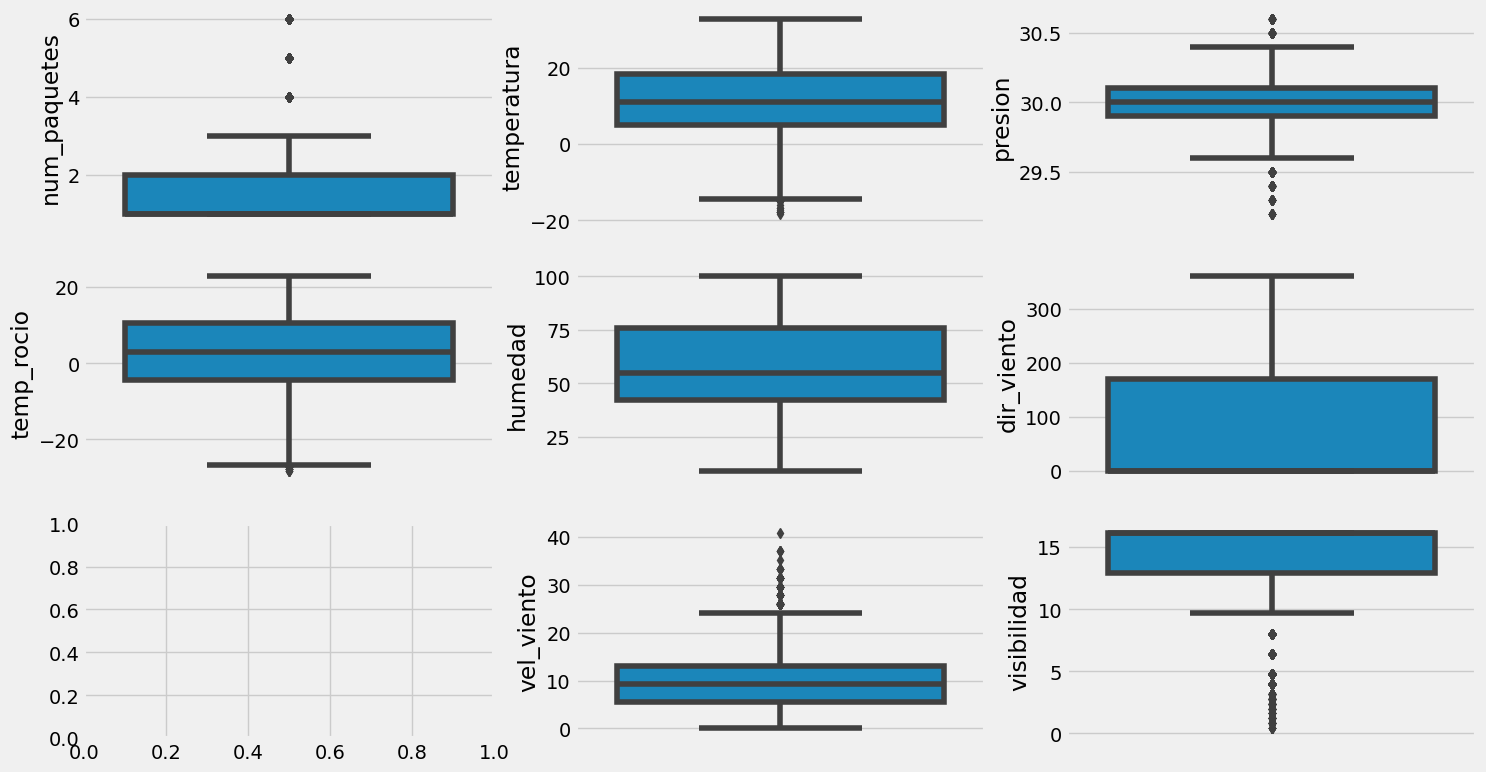

In [ ]:
#Para identificar outliers
fig,ax = plt.subplots(3,3,figsize=(16,9))
sns.boxplot(data=data,y='num_paquetes',ax=ax[0,0])
sns.boxplot(data=data,y='temperatura',ax=ax[0,1])
sns.boxplot(data=data,y='temp_rocio',ax=ax[1,0])
sns.boxplot(data=data,y='humedad',ax=ax[1,1])
sns.boxplot(data=data,y='dir_viento',ax=ax[1,2])
sns.boxplot(data=data,y='presion',ax=ax[0,2])
sns.boxplot(data=data,y='vel_viento',ax=ax[2,1])
sns.boxplot(data=data,y='visibilidad',ax=ax[2,2])

En el anterior grafico podemos ver los Boxplot de las variables: numero de paquetes, temperatura, temp rocio, humedad, direccion del viento, presion, velocidad del viento y la visibilidad. Lo anterior con el fin de tener a grandes rasgos una idea de como de distirbuyen los datos en la base de datos utilizada en el desarrollo del modelo. 

In [ ]:
#En este caso vamos a imputar la mediana a las columnas que tienen outliers
columnas_outliers = ["num_paquetes","temperatura","presion","dir_viento","vel_viento","visibilidad"]

for columna in columnas_outliers:
    q1 = data[columna].quantile(0.25)
    q3 = data[columna].quantile(0.75)
    iqr = q3-q1 
    limite_arriba = q3 + 1.5*iqr
    limite_abajo = q1 - 1.5*iqr
    mediana = data[columna].median()
    media = data[columna].mean()
    data.loc[data[columna].abs() > limite_arriba,columna] = np.nan
    data[columna].fillna(mediana, inplace=True)
    data.loc[data[columna].abs() < limite_abajo,columna] = np.nan
    data[columna].fillna(mediana, inplace=True) 

<Axes: ylabel='visibilidad'>

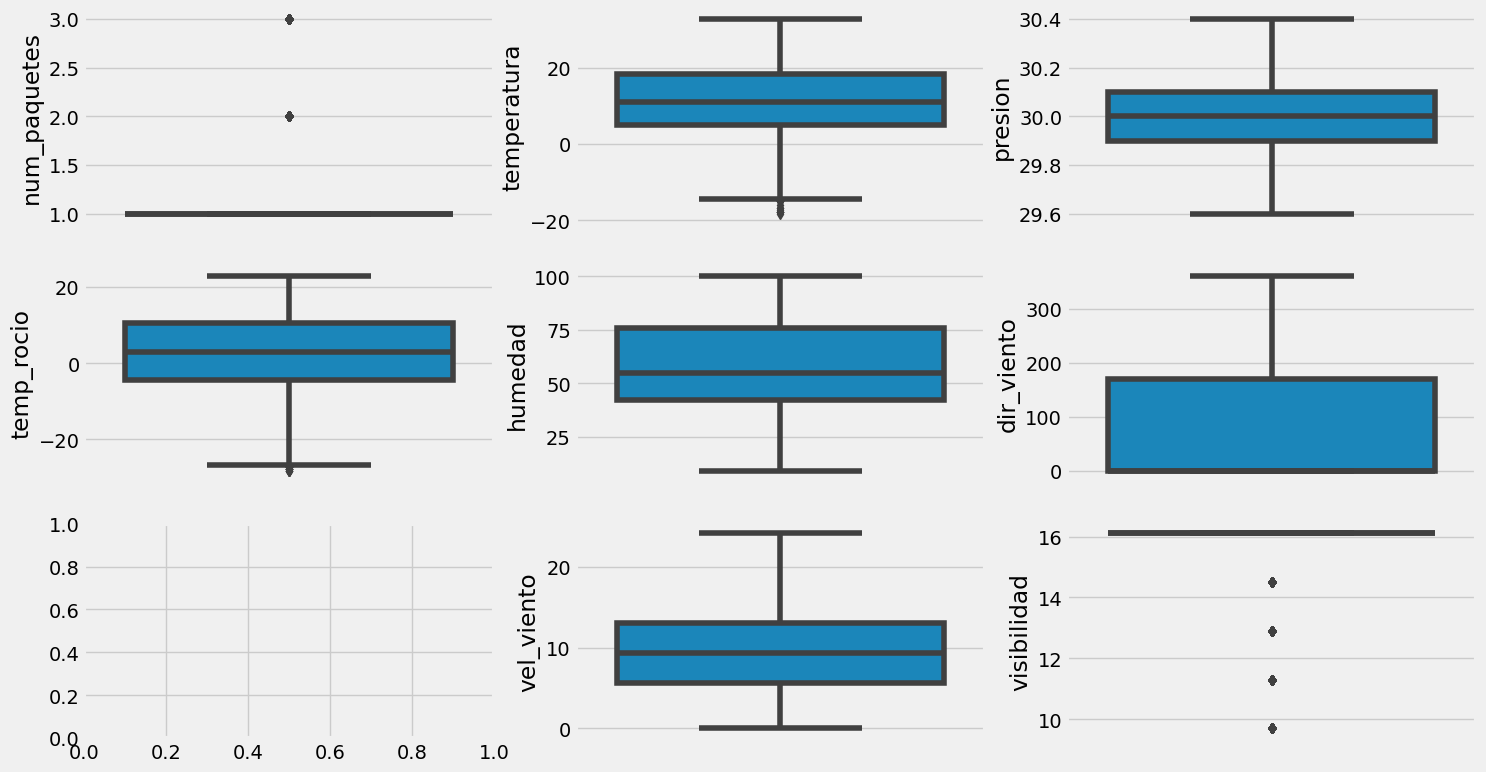

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(16,9))
sns.boxplot(data=data,y='num_paquetes',ax=ax[0,0])
sns.boxplot(data=data,y='temperatura',ax=ax[0,1])
sns.boxplot(data=data,y='temp_rocio',ax=ax[1,0])
sns.boxplot(data=data,y='humedad',ax=ax[1,1])
sns.boxplot(data=data,y='dir_viento',ax=ax[1,2])
sns.boxplot(data=data,y='presion',ax=ax[0,2])
sns.boxplot(data=data,y='vel_viento',ax=ax[2,1])
sns.boxplot(data=data,y='visibilidad',ax=ax[2,2])

# Valores nulos

Para este punto se identifican los valores "Nulos" que se encuentran en el Dataset esto con el fin de tener una mejor precisión en el resultado y oara evitar cualquier afectacion en la ejecucion de los modelos. 

In [ ]:
#Buscar los valores cero dentro del Dataset
data.isna().sum()

modelo_camioneta        0
num_paquetes            0
tiempo_entrega       1274
dataset                 0
condiciones_clima       0
temperatura             0
temp_rocio              2
humedad                 2
vel_viento              0
dir_viento              0
visibilidad             0
presion                 0
ciudad                  0
longitud_inicio         0
latitud_inicio          0
longitud_final          0
latitud_final           0
clima                   0
distance                0
dia                     0
hora                    0
minuto                  0
segundo                 0
dtype: int64

<Axes: xlabel='Count', ylabel='presion'>

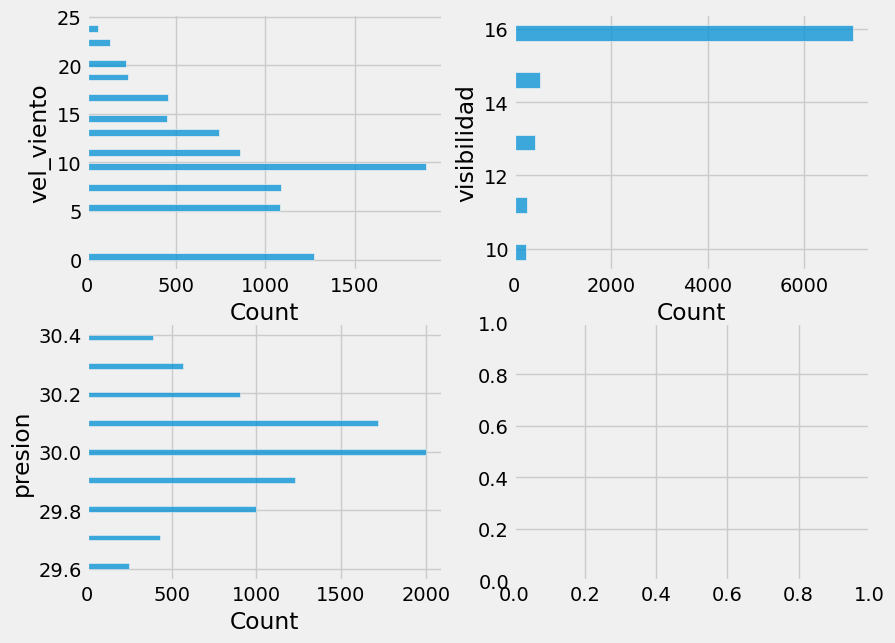

In [ ]:
#Para ver la distribucion de las variables y poderles modificar apropiadamente los valores 0. Para temperatura, humedad y temp_rocio se les 
#remplazaran los valores cero con la mediana 
fig,ax = plt.subplots(2,2,figsize=(9,7))
sns.histplot(data=data,y='vel_viento',ax=ax[0,0])
sns.histplot(data=data,y='visibilidad',ax=ax[0,1])
sns.histplot(data=data,y='presion',ax=ax[1,0])

En el aterior grafico podemos ver como las variables que tenian presencia valores nulos fueron reemplazados por la mediana de cada columna.

In [ ]:
data.loc[data.humedad.isna(),"humedad"]=data.loc[~data.humedad.isna(),"humedad"].median()
data.loc[data.temp_rocio.isna(),"temp_rocio"]=data.loc[~data.humedad.isna(),"temp_rocio"].median()
data.loc[data.temp_rocio.isna(),"temperatura"]=data.loc[~data.humedad.isna(),"temperatura"].median()
data.isna().sum()

modelo_camioneta        0
num_paquetes            0
tiempo_entrega       1274
dataset                 0
condiciones_clima       0
temperatura             0
temp_rocio              0
humedad                 0
vel_viento              0
dir_viento              0
visibilidad             0
presion                 0
ciudad                  0
longitud_inicio         0
latitud_inicio          0
longitud_final          0
latitud_final           0
clima                   0
distance                0
dia                     0
hora                    0
minuto                  0
segundo                 0
dtype: int64

# Transformacion de variables categoricas

Para la transformación de las variables categoricas se decidio utilizar el metodo Cramer siendo esta una técnica de transformación de variables categóricas en numéricas con el fin de poder utilizar las variables modelo de camioneta, la condicion del clima, la ciudad y el clima. Para realizar lo anterior se aplico el respectivo codigo que ejecuta la creación de nuevas variables numéricas que representan la variable original. 

In [ ]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def cramersv_dataframe_target(dataframe,nameTarget):
    df = pd.DataFrame(columns=['v_cramer'],index=dataframe.columns.tolist())
    for col in dataframe.columns.tolist():
        print('V de Cramer para {}: '.format(col) + format(round(cramers_v(dataframe[col],dataframe[nameTarget]),3)))
        df.loc[col,'v_cramer'] = round(cramers_v(dataframe[col],dataframe[nameTarget]),3)
    return df

In [ ]:
def cramersv_dataframe(dataframe):
    df = pd.DataFrame(columns=dataframe.columns.tolist(),index=dataframe.columns.tolist())
    for index in dataframe.columns.tolist():
        for columna in dataframe.columns.tolist():
            df.loc[index,columna] = round(cramers_v(dataframe[index],dataframe[columna]),3)
    return df
        
lista_var_cat = []
for columna in data.columns:
    if data[columna].dtypes=='O':
        lista_var_cat.append(columna)

In [ ]:
cramer_df = cramersv_dataframe(data.loc[:,lista_var_cat])
cramer_df

<ipython-input-392-74d58ecd1976>:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-392-74d58ecd1976>:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-392-74d58ecd1976>:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-392-74d58ecd1976>:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-392-74d58ecd1976>:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-392-74d58ecd1976>:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-392-74d58ecd1976>:12: RuntimeWarning: invalid value encountered in double_scalars
  return 

,modelo_camioneta,dataset,condiciones_clima,ciudad,clima
modelo_camioneta,1.0,0.0,0.025,NaN,0.0
dataset,0.0,1.0,0.0,NaN,0.0
condiciones_clima,0.025,0.0,1.0,NaN,0.649
ciudad,NaN,NaN,NaN,NaN,NaN
clima,0.0,0.0,0.649,NaN,1.0


# Insight #3

Cramer nos permite ver la correlacion entre variables categoricas. Y en este caso se puede ver una fuerte relacion entre clima y condiciones_clima, lo cual es predecible. Y tambien se ve una relacion entre condiciones_clima y el modelo_camioneta

In [ ]:
data['ciudad'].value_counts()

Nueva York    8494
Name: ciudad, dtype: int64

Ya que en Ciudad todos los datos son Nueva York se elimina la variable. Las variables de longitud y latitud tambien se van  a quitar dado que han sido transformadas. Asi mismo la variable condiciones_clima tambien se eliminara ya que ha sido transformada 

In [ ]:

col_eliminar = ["ciudad","longitud_inicio","latitud_inicio","longitud_final","latitud_inicio","condiciones_clima"]
data= data.loc[:,~data.columns.isin(col_eliminar)]
data.head(3)

,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,latitud_final,clima,distance,dia,hora,minuto,segundo
id,,,,,,,,,,,,,,,,,,
1,modelo_1,3.0,448.0,train,8.9,0.0,54.0,16.7,170.0,16.1,30.4,40.814163,Bueno,0.876832,Thursday,20,53,0
2,modelo_2,1.0,784.0,train,22.8,18.9,79.0,9.3,0.0,16.1,30.0,40.786232,Bueno,2.879407,Monday,23,12,0
3,modelo_2,1.0,844.0,train,0.0,-15.6,31.0,9.3,250.0,16.1,30.2,40.726639,Bueno,2.473356,Thursday,11,54,0


En este punto se puede observas que estas variables categoricas como no tienen jerarquia se transforman en numeros


In [ ]:
le = LabelEncoder()
data['modelo_camioneta'] = le.fit_transform(data['modelo_camioneta'])
data['dia'] = le.fit_transform(data['dia'])
#data['festivo'] = le.fit_transform(data['festivo'])
data.head(1)

,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,latitud_final,clima,distance,dia,hora,minuto,segundo
id,,,,,,,,,,,,,,,,,,
1,0,3.0,448.0,train,8.9,0.0,54.0,16.7,170.0,16.1,30.4,40.814163,Bueno,0.876832,4,20,53,0


In [ ]:
#Esta variable categorica si tiene jerarquia 
columnas_encodear = ["clima"]
data_ohe = pd.get_dummies(data, columns=columnas_encodear, prefix='OHE')
data_ohe.head(1)

,modelo_camioneta,num_paquetes,tiempo_entrega,dataset,temperatura,temp_rocio,humedad,vel_viento,dir_viento,visibilidad,presion,latitud_final,distance,dia,hora,minuto,segundo,OHE_Bueno,OHE_lluvia,OHE_niebla,OHE_nieve
id,,,,,,,,,,,,,,,,,,,,,
1,0,3.0,448.0,train,8.9,0.0,54.0,16.7,170.0,16.1,30.4,40.814163,0.876832,4,20,53,0,1,0,0,0


In [ ]:
data_ohe.isna().sum()

modelo_camioneta       0
num_paquetes           0
tiempo_entrega      1274
dataset                0
temperatura            0
temp_rocio             0
humedad                0
vel_viento             0
dir_viento             0
visibilidad            0
presion                0
latitud_final          0
distance               0
dia                    0
hora                   0
minuto                 0
segundo                0
OHE_Bueno              0
OHE_lluvia             0
OHE_niebla             0
OHE_nieve              0
dtype: int64

#Separamos el Train y el Test en df 

In [ ]:
train_df = data_ohe.loc[data_ohe.dataset=='train',data_ohe.columns!='dataset']
test_df = data_ohe.loc[data_ohe.dataset=='test',data_ohe.columns!='dataset']

In [ ]:
X = train_df.loc[:,train_df.columns!="tiempo_entrega"]
y = train_df.loc[:,train_df.columns=="tiempo_entrega"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
MX = MinMaxScaler()
X_train = MX.fit_transform(X_train)
X_test = MX.fit_transform(X_test)

In [ ]:
X_test2 = test_df.loc[:,test_df.columns!='tiempo_entrega']
X_test1=MX.fit_transform(X_test2)

# Arbol de decision

Para este punto de decidio ejecutar un arbol de decision con la base de datos Xtrain y Ytrain con la finalidad de encontrar una predicción adecuada de cual sera el tiempo de entrega del paquete.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
modelo_arbol = DecisionTreeRegressor(max_depth = 5,random_state=15)
modelo_arbol.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=5, random_state=15)

In [ ]:
scores = cross_val_score(modelo_arbol, X_train, y_train, cv = 8, scoring='neg_mean_absolute_error')
scores.mean()

-232.11620192588225

Despues de probar con varios valores en los parametros el mejor resultado en el MAE hallado fue este. Y al subir la prediccion a Kaggle arrojo un valor de 214

In [ ]:
pred_arbol=pd.DataFrame(modelo_arbol.predict(X_test1),columns=["tiempo_entrega"],index=X_test2.index).reset_index()
pred_arbol.target=pred_arbol.tiempo_entrega.astype(int)

<ipython-input-407-8d2c4a3abba8>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  pred_arbol.target=pred_arbol.tiempo_entrega.astype(int)


In [ ]:
#Importamos la prediccion para subirla a kaggle
pred_arbol.to_csv("prediccion_1.csv",index=False)
files.download("prediccion_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Random Forest

Para tener un mejor ajuste evitando el sobreajuste y obteniendo un valor de prediccion mas exacto y adecuado se decidio implementar un Randon forest, el cual tuvo como resultado un mejor puntaje de proyeccion, asi mismo nos da un mejor panorama de cual sera el tiempo mas cercano al que se va a entregar el paquete en sus respectivas camionetas

In [ ]:
from sklearn.ensemble import RandomForestRegressor
modelo_rf=RandomForestRegressor(n_estimators=100,random_state=44, min_samples_leaf=50, min_samples_split=150,max_depth=5, max_features=13)
modelo_rf.fit(X_train,y_train);
scores = cross_val_score(modelo_rf, X_train, y_train, cv = 8, scoring='neg_mean_absolute_error')
print(scores.mean());

<ipython-input-409-0fb3e89898b2>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train,y_train);
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

-226.57117248025955


Despues de probar con varios valores en los parametros el mejor resultado en el MAE hallado fue este. Y al subir la prediccion a Kaggle arrojo un valor de 210

In [ ]:
pred_arbol_pod = pd.DataFrame(modelo_rf.predict(X_test1),columns=['tiempo_entrega'],index=X_test2.index).reset_index()
pred_arbol_pod.tiempo_entrega = pred_arbol_pod.tiempo_entrega.astype(int)

In [ ]:
pred_random_forest.to_csv("prediccion_2.csv",index=False)
files.download("prediccion_2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# XGBoost

En principio de deicidio utilizar esta técnica XGBoost de ajuste de árboles de decisión con el fin de mejorar la precisión de los datos que se estan proyectando y prediciendo, asi como tambien reducir el sobreajuste. Por tanto al ejecutar la función de esta tecnica tuvimos como resultado una mejora en los parametros que pueden ser implementados en los modelos con el fin de tener un mejor plano de predicción.

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(booster='gbtree',random_state=42, n_estimators=100, max_depth=2)

In [ ]:
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
from sklearn.model_selection import cross_val_score
mae_xgb = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
mae_xgb.mean()

-213.6894311426413

In [ ]:
from sklearn.metrics import mean_absolute_error
y_pred_xgb = pd.DataFrame(xgb.predict(X_test),columns=['tiempo_entrega'])
mean_absolute_error(y_test, y_pred_xgb)

205.263300288417

In [ ]:
pred_xgb = pd.DataFrame(xgb.predict(X_test1),columns=['tiempo_entrega'],index=X_test2.index).reset_index()
pred_xgb.tiempo_entrega=pred_xgb.tiempo_entrega.astype(int)

In [ ]:
pred_xgb.to_csv("prediccion_3.csv",index=False)
files.download("prediccion_3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### Hiperparametros

***Grid Search***
Esta técnica de optimización de hiperparámetros busca la combinación óptima de hiperparámetros que maximice el rendimiento del modelo en un conjunto de datos de prueba.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import time

**XGBoost**

In [ ]:
param_grid = {
    'n_estimators':[100,600],
    'max_depth': [2,6],
    'learning_rate':[0.1, 0.6]
}
# Crear modelo con GridSearchCV
model_gridsearch_xgb = GridSearchCV(
    estimator = xgb,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error', 
    n_jobs = 8,
    cv = 50, 
    refit= True,
    return_train_score = True
)

In [ ]:
start = time.time()
# Ajustar el modelo
model_gridsearch_xgb.fit(X_train, y_train)

GridSearchCV(cv=50,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=N...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=2, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=8,
             param_grid={'learning_rate': [0.1, 0.6], 'max_depth': [2, 6],
                         'n_estimators': [100, 600]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
y_pred_grid_xgb = model_gridsearch_xgb.predict(X_test)
mae_grid_xgb = mean_absolute_error(y_test, y_pred_grid_xgb)
mae_grid_xgb

202.00761665069496

In [ ]:
model_gridsearch_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}

In [ ]:
model_gridsearch_xgb.best_score_

-208.34336059275563

In [ ]:
pred_xgb1 = pd.DataFrame(model_gridsearch_xgb.predict(X_test1),columns=['tiempo_entrega'],index=X_test2.index).reset_index()
pred_xgb1.tiempo_entrega=pred_xgb1.tiempo_entrega.astype(int)

In [ ]:
pred_xgb1.to_csv("prediccion_3.csv",index=False)
files.download("prediccion_3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**RF**

In [ ]:
param_grid = {
    'n_estimators':[100,600],
    'max_depth': [4,10],
    'min_samples_leaf':[2,6,10]
}

model_gridsearch_rf = GridSearchCV(
    estimator = modelo_rf,
    param_grid = param_grid,
    scoring = 'neg_mean_absolute_error',
    n_jobs = 8,
    cv = 50, 
    refit= True,
    return_train_score = True
)

In [ ]:
start = time.time()
# Ajustar el modelo
model_gridsearch_rf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=50,
             estimator=RandomForestRegressor(max_depth=5, max_features=13,
                                             min_samples_leaf=50,
                                             min_samples_split=150,
                                             random_state=44),
             n_jobs=8,
             param_grid={'max_depth': [4, 10], 'min_samples_leaf': [2, 6, 10],
                         'n_estimators': [100, 600]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
y_pred_grid_rf = model_gridsearch_rf.predict(X_test)
mean_absolute_error(y_test,y_pred_grid_rf)

207.52999718860104

In [ ]:
model_gridsearch_rf.best_params_

{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 100}

In [ ]:
model_gridsearch_rf.best_score_

-217.21740632792864

In [ ]:
pred_rf1 = pd.DataFrame(model_gridsearch_rf.predict(X_test1),columns=['tiempo_entrega'],index=X_test2.index).reset_index()
pred_rf1.tiempo_entrega=pred_rf1.tiempo_entrega.astype(int)

In [ ]:
pred_rf1.to_csv("prediccion_3.csv",index=False)
files.download("prediccion_3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Random Search

Continuando con el mejoramiento de los modelos, se utilizo la tecnica de ajuste de hiperparametros Random Search, con el principal objetuvo de encontrar la mejor combinación de hiperparámetros para el modelo establecido. El manejo de esta tecnica se centra en realizar una búsqueda aleatoria en el espacio de hiperparámetros para asi eligir combinaciones de hiperparámetros al azar que posteriormente seran evaluadas para determinar si estas pueden mejorar la prediccion de los modelos. 



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
param_dist ={
    'n_estimators': list(range(160,220,10)),
    'min_samples_leaf':list(range(3,10)),
    'max_depth': list(range(4,10,2))
}

n_iter = 50

# Crear modelo RandomizedSearchCV
model_random_search = RandomizedSearchCV(
    estimator = modelo_rf,
    param_distributions = param_dist,
    n_iter = n_iter,
    n_jobs = 8

)

In [ ]:
start = time.time()
# Ajustar el modelo
model_random_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(estimator=RandomForestRegressor(max_depth=5, max_features=13,
                                                   min_samples_leaf=50,
                                                   min_samples_split=150,
                                                   random_state=44),
                   n_iter=50, n_jobs=8,
                   param_distributions={'max_depth': [4, 6, 8],
                                        'min_samples_leaf': [3, 4, 5, 6, 7, 8,
                                                             9],
                                        'n_estimators': [160, 170, 180, 190,
                                                         200, 210]})

In [ ]:
y_pred_grid_rs = model_random_search.predict(X_test)
mean_absolute_error(y_test,y_pred_grid_rs)

208.35309419736038

In [ ]:
model_random_search.best_params_

{'n_estimators': 200, 'min_samples_leaf': 4, 'max_depth': 8}

In [ ]:
model_random_search.best_score_

0.6478558606450842

In [ ]:
pred_rs = pd.DataFrame(model_random_search.predict(X_test1),columns=['tiempo_entrega'],index=X_test2.index).reset_index()
pred_rs.tiempo_entrega=pred_rs.tiempo_entrega.astype(int)

In [ ]:
pred_rs.to_csv("prediccion_3.csv",index=False)
files.download("prediccion_3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>